In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT/"src"))

# Startup checks
from config import CLEAN_FILE
from startup_checks import ensure_project_dirs, check_required_data

ensure_project_dirs()
check_required_data(CLEAN_FILE)

print("Clean data:", CLEAN_FILE)

Clean data: /home/tl/stock-news-sentiment-bert-finbert/data/processed/financial_phrasebank_clean.csv


In [2]:
from config import TEXT_COL, BERT_KEY, FINBERT_KEY, HF_MODELS
from preprocess import load_and_clean_data
from utils import token_length_summary, generate_truncation_candidates, truncation_rate, compare_computational_cost_info
from artifacts_utils import save_tokenization_config, save_tokenization_analysis, save_truncation_shortlist

from transformers import AutoTokenizer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load dataset
df = load_and_clean_data(CLEAN_FILE, basic_clean=False, clean_label=False)    # Load cleaned dataset generated in Notebook 01 (labels already normalized)

In [4]:
# Load Hugging Face model config
bert_model_id = HF_MODELS[BERT_KEY]["model_id"]
finbert_model_id = HF_MODELS[FINBERT_KEY]["model_id"]

print(f"bert_model_id = {bert_model_id}")
print(f"finbert_model_id = {finbert_model_id}")

bert_model_id = bert-base-uncased
finbert_model_id = ProsusAI/finbert


In [5]:
# Load tokenizers: BERT and FinBERT
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_id, use_fast=True)
finbert_tokenizer = AutoTokenizer.from_pretrained(finbert_model_id, use_fast=True)

print("BERT vocab size:", bert_tokenizer.vocab_size)
print("FinBERT vocab size:", finbert_tokenizer.vocab_size)

BERT vocab size: 30522
FinBERT vocab size: 30522


In [6]:
# Transfomer token length statistics
texts = df[TEXT_COL].astype(str).tolist()

bert_token_lengths = [len(bert_tokenizer.encode(text, add_special_tokens=True)) for text in texts]
finbert_token_lengths = [len(finbert_tokenizer.encode(text, add_special_tokens=True)) for text in texts]

df_lens = pd.DataFrame({
    "bert_len": bert_token_lengths,
    "finbert_len": finbert_token_lengths
})

print(df_lens.describe())

          bert_len  finbert_len
count  5842.000000  5842.000000
mean     29.439404    29.439404
std      13.603019    13.603019
min       4.000000     4.000000
25%      19.000000    19.000000
50%      27.000000    27.000000
75%      37.000000    37.000000
max     150.000000   150.000000


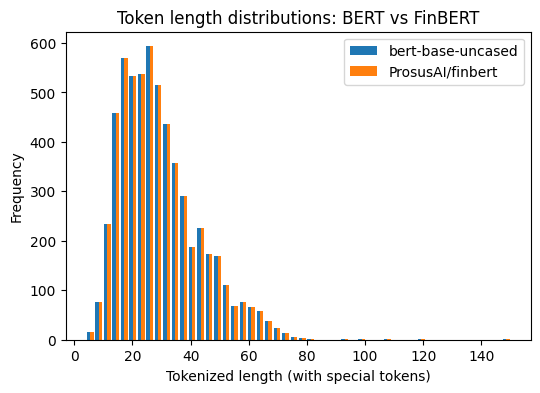

In [7]:
# Visualize token length distributions
plt.figure(figsize=(6,4))
plt.hist([df_lens["bert_len"], df_lens["finbert_len"]], bins=50, label=[bert_model_id, finbert_model_id])
plt.title("Token length distributions: BERT vs FinBERT")
plt.xlabel("Tokenized length (with special tokens)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [8]:
# Token lengths percentile summary
bert_stats = token_length_summary(bert_model_id, bert_token_lengths)
finbert_stats = token_length_summary(finbert_model_id, finbert_token_lengths)

df_stats = pd.DataFrame([bert_stats, finbert_stats])
display(df_stats)

,tokenizer,sample_size,mean,p50,p90,p95,p99,max
0,bert-base-uncased,5842,29.439404,27,48,56,68,150
1,ProsusAI/finbert,5842,29.439404,27,48,56,68,150


In [9]:
# Truncation rate statistics
# Use the combined range (min p95, max max) across tokenizers to ensure all plausible max_length candidates are evaluated
start = min(bert_stats["p95"], finbert_stats["p95"])
end = max(bert_stats["max"], finbert_stats["max"])
candidates = generate_truncation_candidates(start=start, end=end)
print(f"candidates = {candidates}")

rows = []
for candidate in candidates:
    bert_tr = truncation_rate(bert_token_lengths, candidate)
    fin_tr = truncation_rate(finbert_token_lengths, candidate)
    
    rows.append({
        "max_length": candidate,
        "bert_trunc_%": bert_tr,
        "finbert_trunc_%": fin_tr,
        "worst_trunc_%": max(bert_tr, fin_tr),
    })

df_trunc = pd.DataFrame(rows)
display(df_trunc)

candidates = [64, 96, 128]


,max_length,bert_trunc_%,finbert_trunc_%,worst_trunc_%
0,64,1.865799,1.865799,1.865799
1,96,0.068470,0.068470,0.068470
2,128,0.017117,0.017117,0.017117


In [10]:
# Truncation–Efficiency Trade-off Analysis (max_length selection)
threshold = 1.0    # Set a strict worst-case truncation <= 1% to minimize information loss

df_trunc_shortlist = df_trunc[df_trunc["worst_trunc_%"] <= threshold].copy()

if df_trunc_shortlist.empty:
    raise RuntimeError(f"Truncation shortlist is empty with threshold {threshold:.1f}%")

display(df_trunc_shortlist)

trunc_shortlist_candidates = df_trunc_shortlist["max_length"].sort_values().tolist()
print(f"trunc_shortlist_candidates = {trunc_shortlist_candidates}")

baseline_max_length = trunc_shortlist_candidates[0]    # Min. value in the trunc_shortlist_candidates
print(f"Baseline max_length (min under threshold): {baseline_max_length}")

total_sample_size = len(df)

if len(trunc_shortlist_candidates) > 1:
    for candidate in trunc_shortlist_candidates[1:]:
        # BERT
        compare_computational_cost_info(
            name="BERT",
            candidate=bert_token_lengths,
            token_len_from=baseline_max_length,
            token_len_to=candidate,
            total_sample_size=total_sample_size
        )
        
        # FinBERT
        compare_computational_cost_info(
            name="FinBERT",
            candidate=finbert_token_lengths,
            token_len_from=baseline_max_length,
            token_len_to=candidate,
            total_sample_size=total_sample_size
        )
        print("-" * 60)
else:
    print("Since there is only 1 shortlisted candidate, no comparison can be made.")

chosen_max_length = baseline_max_length
print(f"\nChosen max_length: {chosen_max_length}")

,max_length,bert_trunc_%,finbert_trunc_%,worst_trunc_%
1,96,0.068470,0.068470,0.068470
2,128,0.017117,0.017117,0.017117


trunc_shortlist_candidates = [96, 128]
Baseline max_length (min under threshold): 96

Model: BERT
Max length: 96 -> 128
Computational cost (O(L^2) proxy) increased: 77.78%
Truncation rate decreased: 0.05%
Total sample size: 5842
Saved samples: 3.0

Model: FinBERT
Max length: 96 -> 128
Computational cost (O(L^2) proxy) increased: 77.78%
Truncation rate decreased: 0.05%
Total sample size: 5842
Saved samples: 3.0
------------------------------------------------------------

Chosen max_length: 96


In [11]:
# Save tokenization configuration
tokenization_cfg = {
    "baseline_max_length": int(baseline_max_length),
    "max_length": int(chosen_max_length),
    "padding": "max_length",
    "truncation": True,
    "selection_method": "truncation_efficiency_tradeoff",
    "truncation_threshold_pct": float(threshold)
}

token_cfg_path = save_tokenization_config(tokenization_cfg)
print("Saved tokenization configuration to:", token_cfg_path)

Saved to /home/tl/stock-news-sentiment-bert-finbert/artifacts/preprocessing/tokenization_config.json
Saved tokenization configuration to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/preprocessing/tokenization_config.json


In [12]:
# Save token length statiscs and truncation rates artifacts
token_length_stats_path, truncation_rates_path = save_tokenization_analysis(
    df_stats=df_stats,
    df_trunc=df_trunc,
)

print("Saved token length statistics to:", token_length_stats_path)
print("Saved truncation rates to:", truncation_rates_path)

Token length statistics saved to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/comparison/token_length_stats.csv
Truncation rates saved to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/comparison/truncation_rates.csv
Saved token length statistics to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/comparison/token_length_stats.csv
Saved truncation rates to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/comparison/truncation_rates.csv


In [13]:
# Save truncation shortlist artifacts
truncation_shortlist_path = save_truncation_shortlist(
    df_trunc_shortlist=df_trunc_shortlist,
    threshold=threshold,
)

print("Saved truncation shortlist to:", truncation_shortlist_path)

Truncation shortlist saved to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/comparison/truncation_shortlist_threshold_1_0.csv
Saved truncation shortlist to: /home/tl/stock-news-sentiment-bert-finbert/artifacts/results/comparison/truncation_shortlist_threshold_1_0.csv


## Summary - Tokenizer Analysis & max_length Selection

### Objective
To analyze and compare tokenization behaviors of **BERT** and **FinBERT**, and to determine an appropriate **max_length** for Transformer-based sentiment classification that balances information retention and computational efficiency.

### Work Performed
- Tokenized all sentences using **Hugging Face**
  - **BERT (bert-base-uncased)**
  - **FinBERT (domain-specific financial pretrained model)**
- Analyzed tokenized sequence length distributions
  - Descriptive statistics (mean, std, percentiles, max length)
  - Histogram-based visualization for comparison
- Generated GPU-friendly **max_length** candidates based on
  - Power of 2
  - Multiples of 32 (hardware-aligned)
- Computed truncation rates for each candidate across both tokenizers
- Performed trade-off analysis
  - **Truncation rate reduction** vs **Computational cost (O(L²) proxy)**
 
### Key Decisions
- A single shared **max_length** is selected for both BERT and FinBERT to ensure fair comparison
- Candidate selection is driven by worst-case truncation across tokenizers
- A strict truncation threshold (≤ 1%) is used to minimize information loss
- Relative attention cost is approximated using quadratic scaling (O(L²)) for comparison

### Results
- Token length distributions of BERT and FinBERT are highly similar on this dataset
- Increasing `max_length` beyond a certain point yields diminishing returns in truncation reduction while incurring substantial computational cost
- Based on truncation–efficiency trade-off analysis, **max_length = 96** is selected as a balanced and efficient configuration for subsequent experiments

### Artifacts Produced
- Tokenization configuration:
  - **artifacts/preprocessing/tokenization_config.**
- Token length statistics:
  - **artifacts/results/comparison/token_length_stats.csv**
- Truncation rate tables across candidates:
  - **artifacts/results/comparison/truncation_rates.csv**
- Truncation shortlist candidates:
  - **artifacts/results/comparison/truncation_shortlist_threshold_1_0.csv**

### Takeaway
This notebook establishes a data-driven and hardware-aware **max_length** selection strategy, providing a consistent and efficient configuration for downstream BERT and FinBERT fine-tuning experiments.